In [1]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [2]:
# You need to change that to your project directory

PROJECT_DIR = '/Users/simon.cazals/Desktop/projects/steel'

In [3]:
DATA_DIR = os.path.join(PROJECT_DIR, 'data')

In [4]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 1600
IMAGE_CHANNELS = 3

# Load data

In [5]:
train_image_files = glob.glob(os.path.join(DATA_DIR, 'train_images', '*.jpg'))
test_image_files = glob.glob(os.path.join(DATA_DIR, 'test_images', '*.jpg'))
print("{} images in the train set !".format(len(train_image_files)))
print("{} images in the test set !".format(len(test_image_files)))

12568 images in the train set !
1801 images in the test set !


In [6]:
train_image_files[0]

'/Users/simon.cazals/Desktop/projects/steel/data/train_images/58ee62fd7.jpg'

In [19]:
train_labels_file = os.path.join(DATA_DIR, 'train.csv')
train_df = pd.read_csv(train_labels_file)

print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [56]:
image_id_to_file = {f.split('/')[-1].split('.')[0]: f for f in train_image_files}
image_ids = list(image_id_to_file.keys())

In [57]:
image_id_class_id_to_mask = dict(zip(train_df.ImageId_ClassId, train_df.EncodedPixels))
image_id_to_masks = {image_id : [image_id_class_id_to_mask['{}.jpg_{}'.format(image_id, i+1)] for i in range(4)] 
                     for image_id in image_ids}

In [64]:
type(image_id_to_masks['58ee62fd7'][0])

float

# Visualize 

### Utility functions

In [98]:
def mask_to_rle(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    
    return run_lengths

def rle_to_mask(rle_string):
    if isinstance(rle_string, float) and math.isnan(rle_string):
        return np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint8)
    
    rle_int = list(map(int, rle_string.split(' ')))
    rle_pair = np.array(rle_int).reshape(-1, 2)
    
    img = np.zeros(IMAGE_HEIGHT * IMAGE_WIDTH,dtype=np.uint8)
    for index, length in rle_pair:
        index -= 1
        img[index: index+length] = 255
    
    img = img.reshape(IMAGE_WIDTH, IMAGE_HEIGHT)
    img = img.T
    return img

def masks_to_mask(mask_list):
    assert len(mask_list) == 4, "The list of masks should be of length 4."
    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    
    colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255)]
    for i in range(4):
        for c in range(3):
            mask[:, :, c] += colors[i][c] * mask_list[i]
    return mask

### Plot

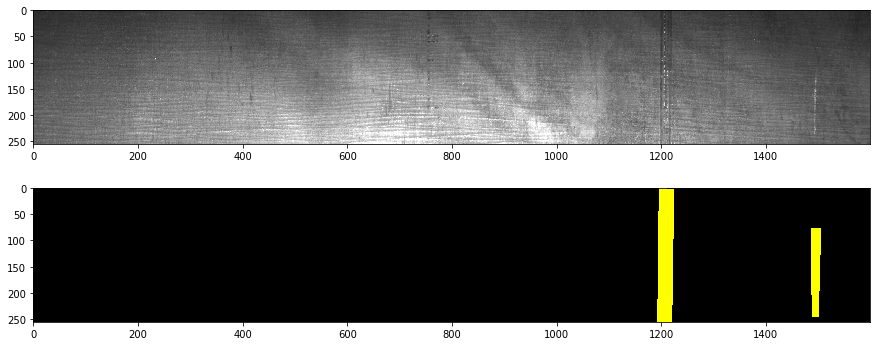

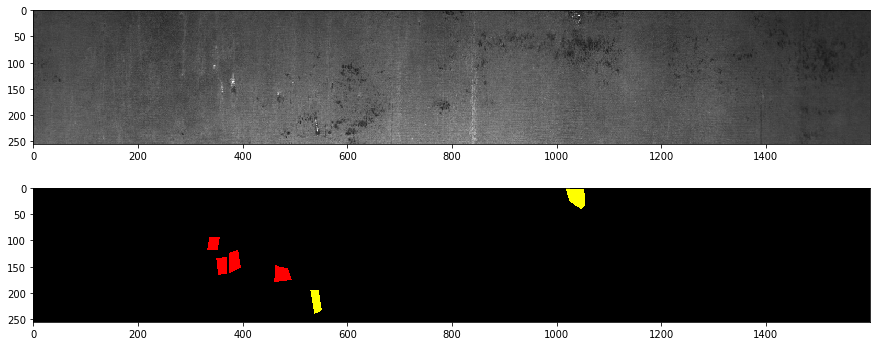

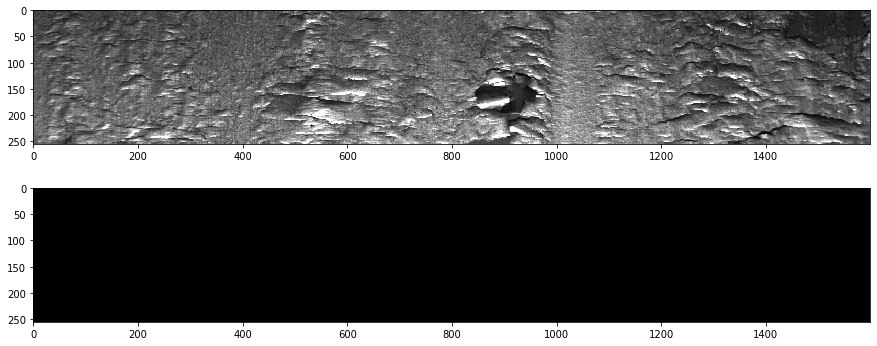

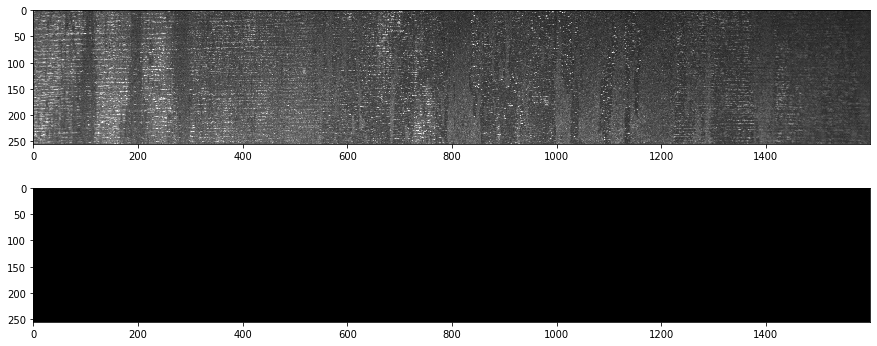

In [108]:
for image_id in image_ids[:4]:
    image = Image.open(image_id_to_file[image_id])
    
    rle_masks = image_id_to_masks[image_id]
    masks = [rle_to_mask(rle_mask) for rle_mask in rle_masks]
    mask = masks_to_mask(masks)
    
    fig=plt.figure(figsize=(15, 6))
    plt.subplot(2,1,1)
    plt.imshow(image)
    plt.subplot(2,1,2)
    plt.imshow(mask)
    plt.show()